# Лабораторная работа №5
Выполнил: Шипилов К. Ю.
Группа: М8О-403Б-22

## Классификация

В качестве датасета выбран tawfikelmetwally/employee-dataset. Используя этот датасет можно обучить модель для выявления сотрудников, которые собираются покинуть компанию, и оценить влияние различных факторов на уход сотрудников из компании.

Импорт библиотек, функций и классов для подготовки данных, обучения и оценки моделей.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

Чтение датасета из файла.

In [2]:
df = pd.read_csv("./datasets/Employee.csv")
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


Проверка типов признаков в датасете и наличия пропусков. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


Описание числовых признаков.

In [4]:
df.describe()

,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot
count,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000
mean,2015.062970,2.698259,29.393295,2.905652,0.343864
std,1.863377,0.561435,4.826087,1.558240,0.475047
min,2012.000000,1.000000,22.000000,0.000000,0.000000
25%,2013.000000,3.000000,26.000000,2.000000,0.000000
50%,2015.000000,3.000000,28.000000,3.000000,0.000000
75%,2017.000000,3.000000,32.000000,4.000000,1.000000
max,2018.000000,3.000000,41.000000,7.000000,1.000000


Распределение таргета.

In [5]:
target = "LeaveOrNot"
df["LeaveOrNot"].value_counts()

LeaveOrNot
0    3053
1    1600
Name: count, dtype: int64

Разделение выборки на тренировочную и тестовую с сохранением баланса таргета. Также определяются названия категориальных и численных признаков, для более удобной обработки данных.

In [6]:
y = df[target]
X = df.drop(columns=[target])

num_cols = ["JoiningYear", "Age", "ExperienceInCurrentDomain"]
cat_cols = ["Education", "City", "PaymentTier", "Gender", "EverBenched"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

Функция оценки метрик классификации.

Главной метрикой выбрана ROC AUC, поскольку она оценивает качество ранжирования объектов по вероятности принадлежности к положительному классу. В отличие от метрик, зависящих от фиксированного порога (например, Accuracy или F1), ROC AUC агрегирует результаты по всем возможным порогам и показывает, насколько стабильно модель отделяет положительные объекты от отрицательных. 

In [7]:
def evaluate_classification(y_true, y_pred, y_proba):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba)
    }

### Бейзлайн

В качестве бейзлайна используется пайплайн, в котором к категориальным признакам применяется OrdinalEncoder (значения кодируются целыми неотрицательными числами), после чего применяется GradientBoostingClassifier.

In [8]:
encoder = ColumnTransformer([
    ("cat", OrdinalEncoder(), cat_cols),
    ("num", "passthrough", num_cols)
])

base = Pipeline([
    ("preprocess", encoder),
    ("gb", GradientBoostingClassifier())
])

base.fit(X_train, y_train)

y_pred = base.predict(X_test)
y_proba = base.predict_proba(X_test)[:, 1]

baseline_metrics = evaluate_classification(y_test, y_pred, y_proba)
baseline_metrics

{'accuracy': 0.8474758324382384,
 'precision': 0.8803418803418803,
 'recall': 0.64375,
 'f1': 0.7436823104693141,
 'roc_auc': 0.8539279869067105}

Функция для отображения матрицы ошибок

In [9]:
def display_confusion_matrix(y_test, y_pred):
    con = confusion_matrix(y_test, y_pred)
    con_display = ConfusionMatrixDisplay(con)
    con_display.plot()
    plt.show()

Матрица ошибок

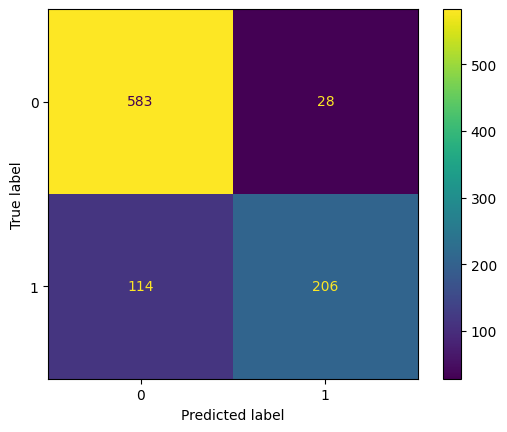

In [10]:
display_confusion_matrix(y_test, y_pred)

### Улучшение бейзлайна

Для начала закодируем категориальные признаки с помощью One Hot Encoder. Также первое значение признака отбрасывается, так как его можно выразить через остальные. Выведем полученный датасет.

In [11]:
encoder = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), cat_cols),
    ("num", "passthrough", num_cols)
])

X_train_enc = encoder.fit_transform(X_train)

ohe = encoder.named_transformers_["cat"]
ohe_cols = ohe.get_feature_names_out(cat_cols)
all_cols = list(ohe_cols) + num_cols

df_plot = pd.DataFrame(X_train_enc, columns=all_cols, index=X_train.index)
df_plot[target] = y_train
df_plot.head()

,Education_Masters,Education_PHD,City_New Delhi,City_Pune,PaymentTier_2,PaymentTier_3,Gender_Male,EverBenched_Yes,JoiningYear,Age,ExperienceInCurrentDomain,LeaveOrNot
1190,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2018.0,25.0,3.0,1
419,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2016.0,28.0,1.0,0
693,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015.0,25.0,3.0,1
3609,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2013.0,38.0,5.0,0
902,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2014.0,25.0,3.0,0


Построим матрицу корреляций признаков и таргета. На графике видно, что большая часть признаков имеет слабую корреляцию с таргетом, и есть признаки с корреляцией близкой к нулю.

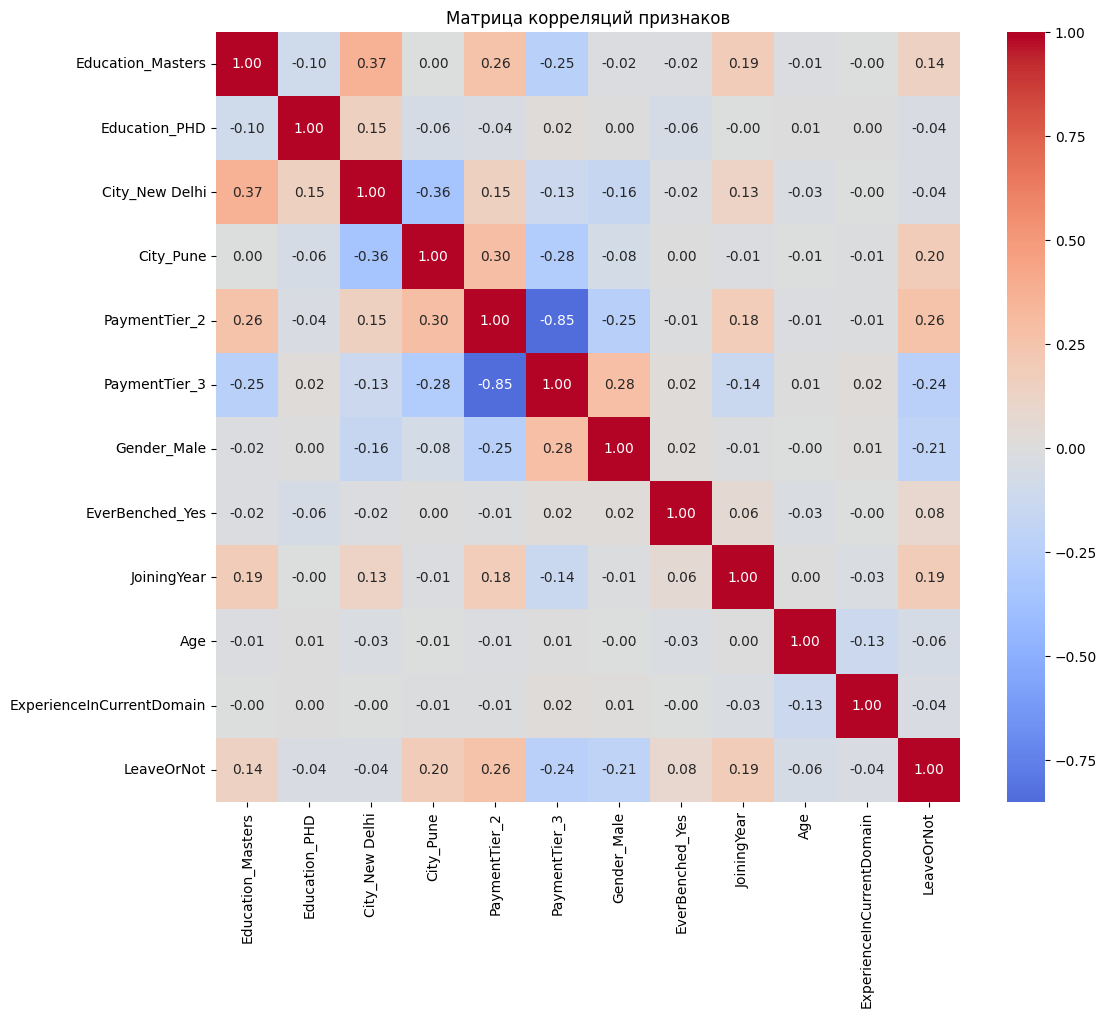

In [12]:
corr = df_plot.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Матрица корреляций признаков")
plt.show()

Построим графики распределения признаков и парные scatter-графики. Разными цветами на графике обозначаются различные значения таргета.

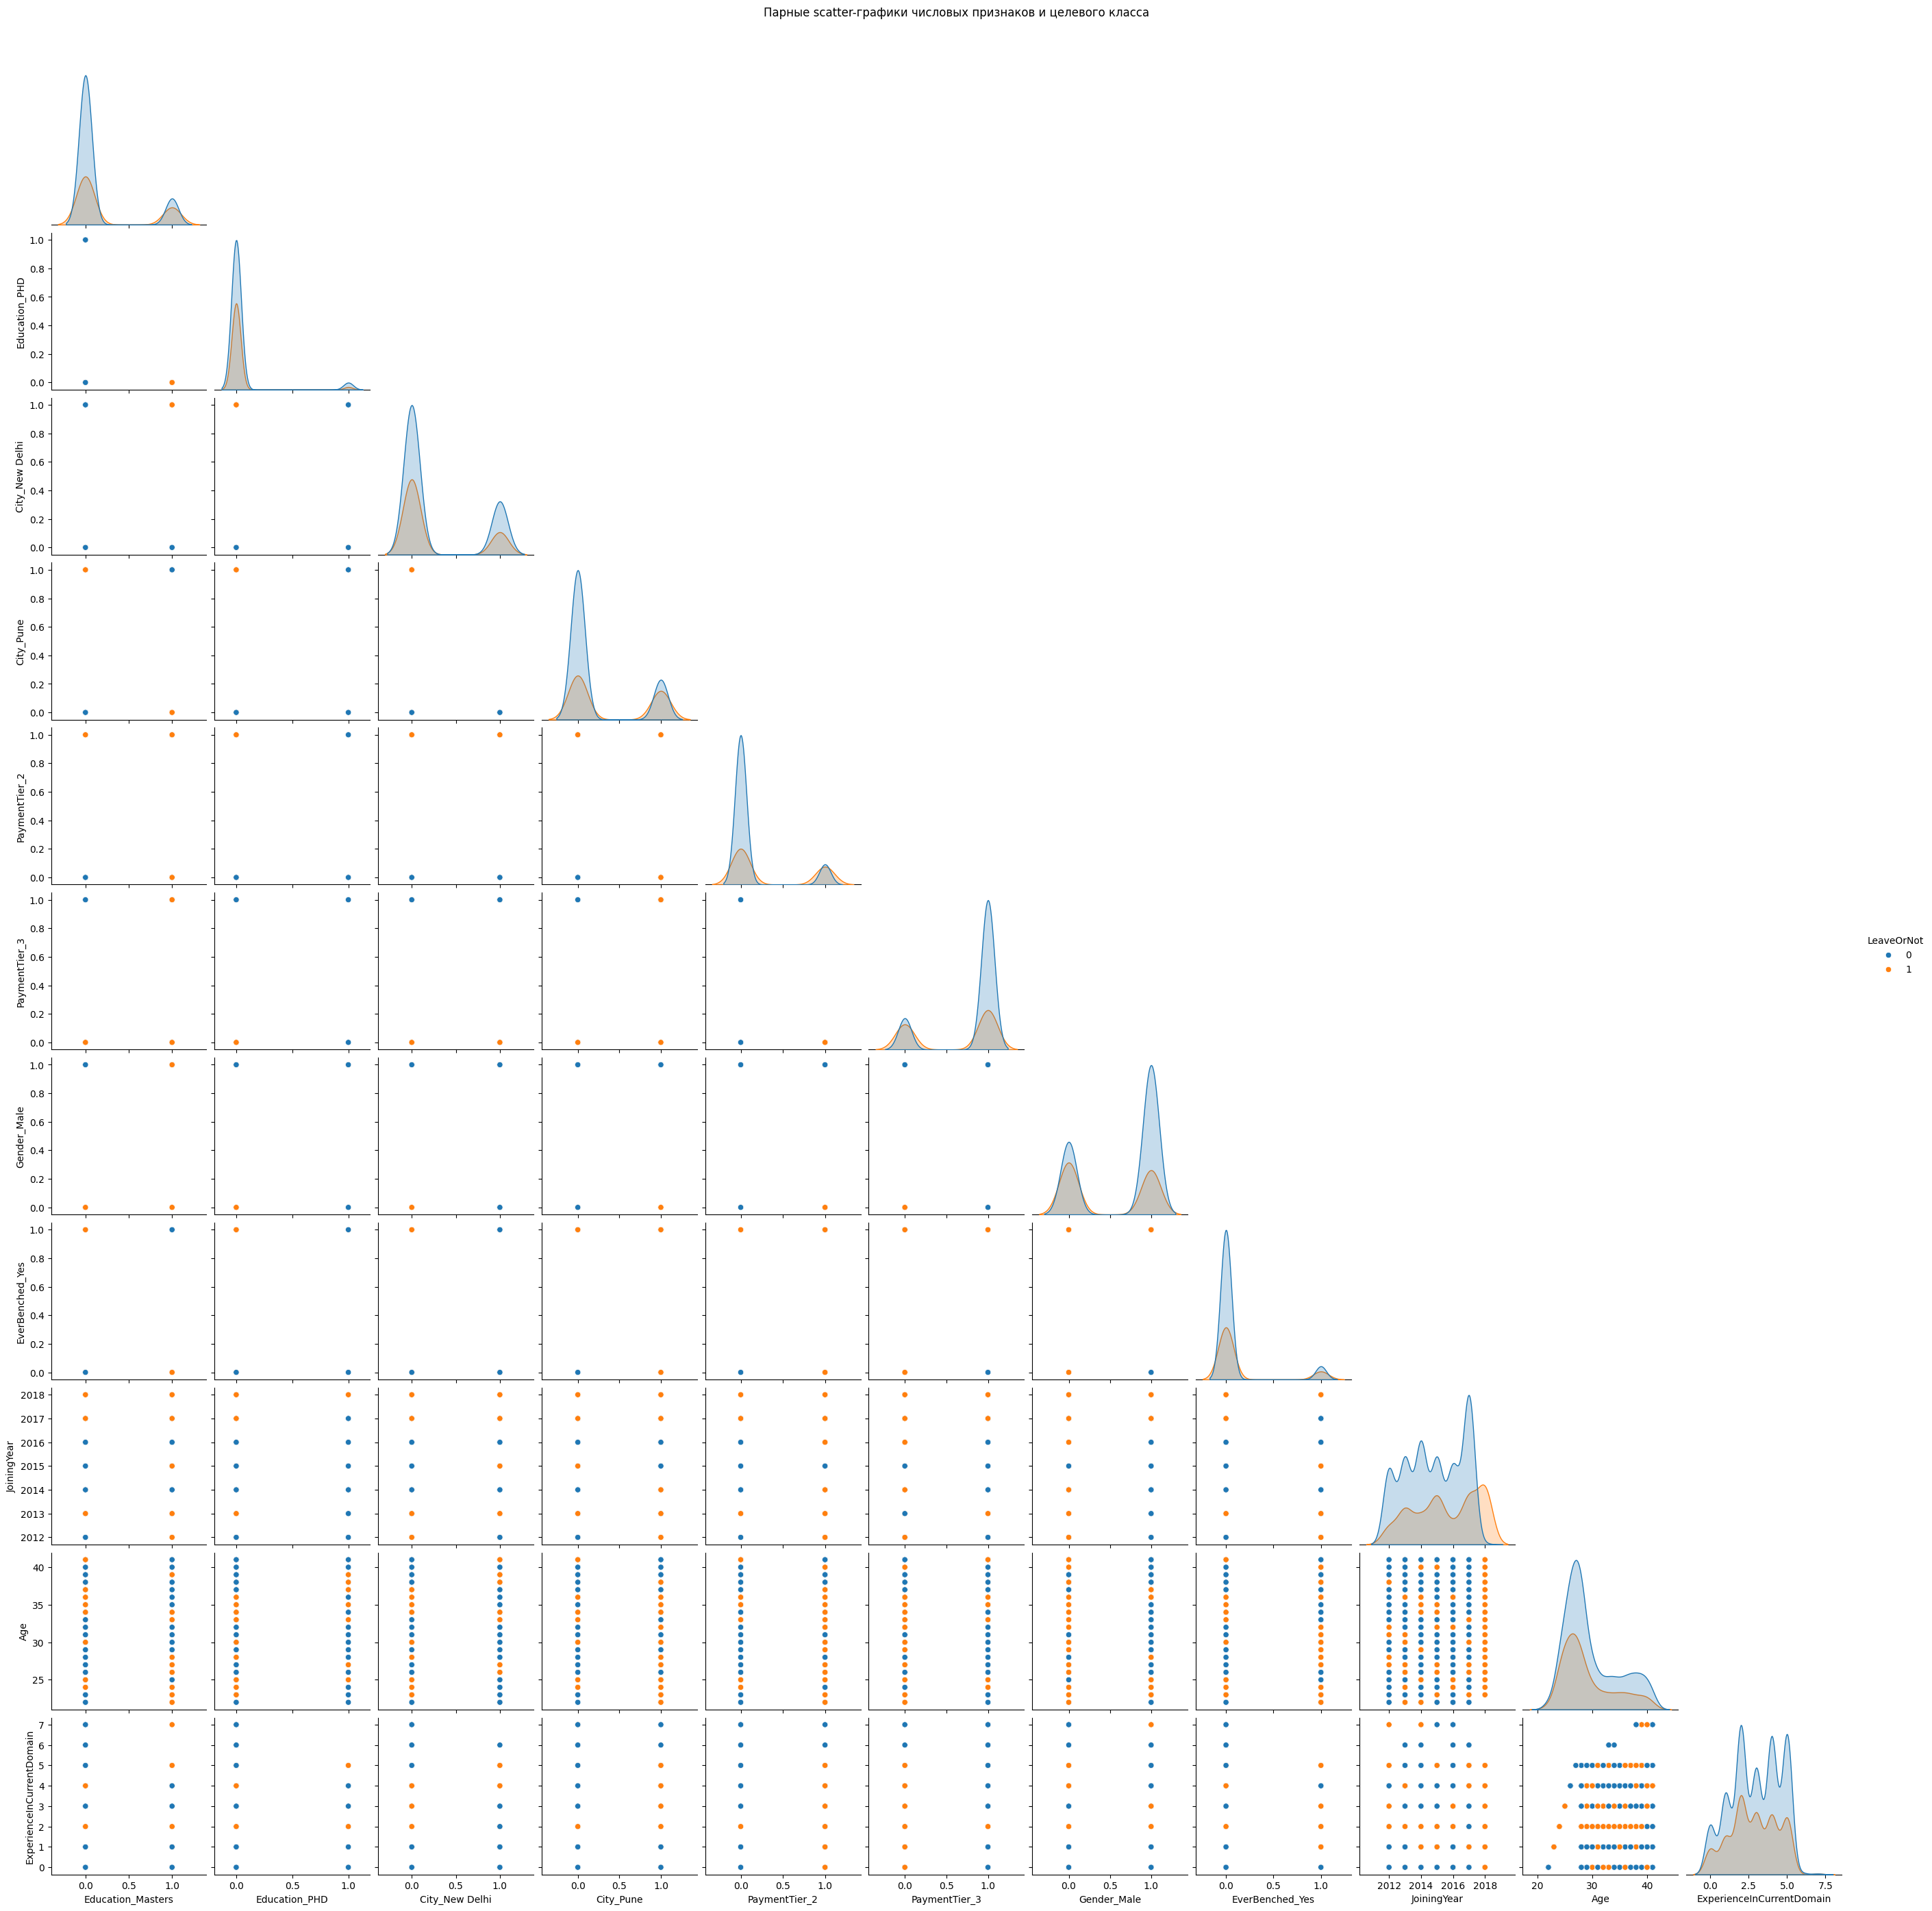

In [13]:
sns.pairplot(df_plot, hue=target, corner=True)
plt.suptitle("Парные scatter-графики числовых признаков и целевого класса", y=1.02)
plt.show()


На графиках boxplot для числовых признаков видно, что в данных отсутствуют выбросы. Но также видно, что числовые признаки имеют разные шкалы, что может негативно сказываться на работе модели.

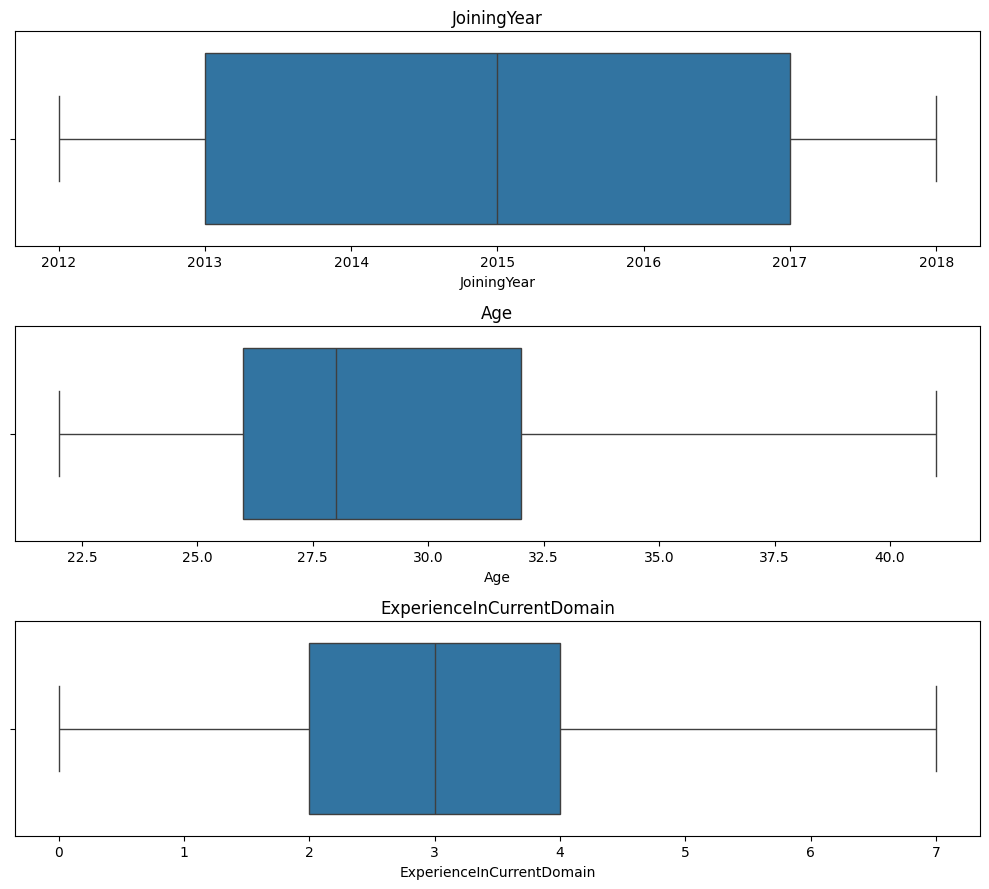

In [14]:
fig, axes = plt.subplots(len(num_cols), 1, figsize=(10, 3 * len(num_cols)))
for ax, col in zip(axes, num_cols):
    sns.boxplot(x=df_plot[col], ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()


Для препроцессинга данных на числовых признаках используется StandardScaler, а на категориальных - OneHotEncoder с отбрасыванием первого значения.

Итоговый пайплайн включает в себя препроцессинг, отбор наиболее значимых признаков и GradientBoostingClassifier.

In [15]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first"), cat_cols)
])

improved = Pipeline([
    ("preprocess", preprocessor),
    ("select", SelectKBest(score_func=f_classif, k=10)),
    ("gb", GradientBoostingClassifier())
])

Для подбора гиперпараметров используется поиск по сетке с кросс валидацией. Фолды для кросс-валидации выбираются с сохранением баланса таргета.

In [16]:
param_grid = {
    "gb__n_estimators": [50, 100, 200],
    "gb__learning_rate": [0.01, 0.1, 0.2],
    "gb__max_depth": [3, 5, 7]
}

cv = StratifiedKFold(n_splits=5, shuffle=True)

gs = GridSearchCV(
    improved, param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

gs.fit(X_train, y_train)
gs.best_params_

{'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__n_estimators': 50}

Оценка предсказания лучшей модели на тестовой выборке

In [17]:
best_model = gs.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

improved_metrics = evaluate_classification(y_test, y_pred, y_proba)
improved_metrics

{'accuracy': 0.841031149301826,
 'precision': 0.864406779661017,
 'recall': 0.6375,
 'f1': 0.7338129496402878,
 'roc_auc': 0.8610909369885433}

Матрица ошибок

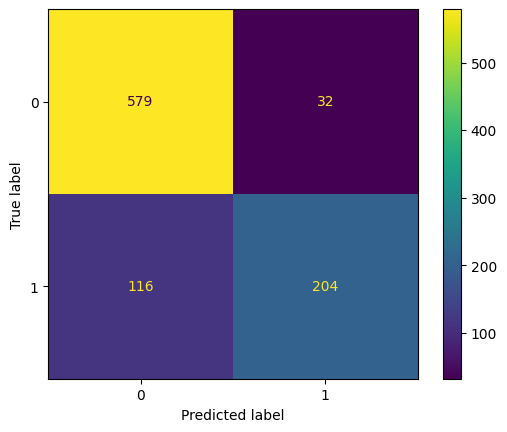

In [18]:
display_confusion_matrix(y_test, y_pred)

Функция для сравнения различных моделей по ментрикам.

In [19]:
def compare_metrics(metrics_df):
    df_melted = metrics_df.reset_index().melt(id_vars='index', var_name='model', value_name='score')

    sns.barplot(data=df_melted, x='index', y='score', hue='model')
    plt.title("Сравнение метрик")
    plt.ylabel("Score")
    plt.xlabel("Метрика")
    plt.legend(title="Модель")
    plt.tight_layout()
    plt.show()

Сравнение бейзлайна и улучшенной модели

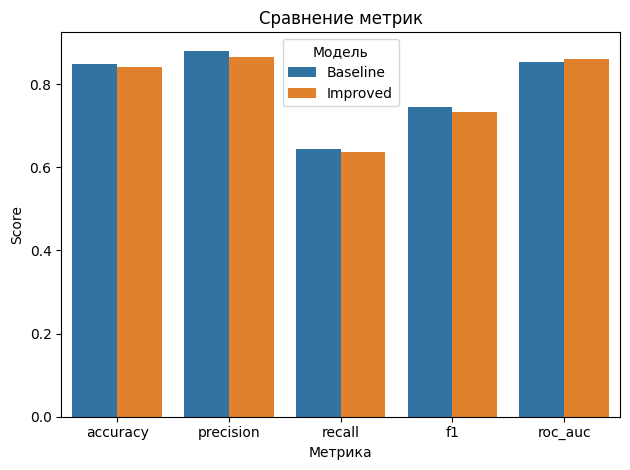

In [20]:
comparison_sklearn = pd.DataFrame({
    "Baseline": baseline_metrics,
    "Improved": improved_metrics
})

compare_metrics(comparison_sklearn)

### Собственная реализация алгоритма 
Имплементация решающего дерева

In [21]:
class CustomDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        criterion="gini",
        max_features=None,
        random_state=None,
    ):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.max_features = max_features
        self.random_state = random_state

    def _gini(self, y):
        p = np.bincount(y) / len(y)
        return 1 - np.sum(p ** 2)

    def _entropy(self, y):
        p = np.bincount(y) / len(y)
        p = p[p > 0]
        return -np.sum(p * np.log2(p))

    def _impurity(self, y):
        return self._gini(y) if self.criterion == "gini" else self._entropy(y)

    def _resolve_max_features(self, n_features):
        if self.max_features is None:
            return n_features
        if isinstance(self.max_features, int):
            return self.max_features
        if isinstance(self.max_features, float):
            return int(self.max_features * n_features)
        if self.max_features == "sqrt":
            return int(np.sqrt(n_features))
        if self.max_features == "log2":
            return int(np.log2(n_features))
        return n_features

    def _best_split(self, X, y):
        best_impurity = np.inf
        best_feature, best_threshold = None, None
    
        n_features = X.shape[1]
        max_feats = self._resolve_max_features(n_features)
    
        feature_indices = self._rng.choice(
            n_features, max_feats, replace=False
        )
    
        for feature_idx in feature_indices:
            for threshold in np.unique(X[:, feature_idx]):
                left = X[:, feature_idx] <= threshold
                right = ~left
    
                if left.sum() < self.min_samples_leaf or right.sum() < self.min_samples_leaf:
                    continue
    
                impurity = (
                    left.sum() * self._impurity(y[left]) +
                    right.sum() * self._impurity(y[right])
                ) / len(y)
    
                if impurity < best_impurity:
                    best_impurity = impurity
                    best_feature = feature_idx
                    best_threshold = threshold
    
        return best_feature, best_threshold

    def _build_tree(self, X, y, depth):
        counts = np.bincount(y, minlength=len(self.classes_))
        proba = counts / counts.sum()
        node_class = counts.argmax()

        if (
            len(np.unique(y)) == 1
            or len(y) < self.min_samples_split
            or (self.max_depth is not None and depth >= self.max_depth)
        ):
            return {"class": node_class, "proba": proba}

        feature, threshold = self._best_split(X, y)
        if feature is None:
            return {"class": node_class, "proba": proba}

        left = X[:, feature] <= threshold
        right = ~left

        return {
            "feature": feature,
            "threshold": threshold,
            "left": self._build_tree(X[left], y[left], depth + 1),
            "right": self._build_tree(X[right], y[right], depth + 1),
        }
    
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y, dtype=int)
    
        self.classes_ = np.unique(y)
        self.n_features_in_ = X.shape[1]
    
        self._rng = np.random.RandomState(self.random_state)
    
        self.tree_ = self._build_tree(X, y, depth=0)
        return self

    def _predict_sample(self, x, node):
        if "class" in node:
            return node["class"], node["proba"]
        if x[node["feature"]] <= node["threshold"]:
            return self._predict_sample(x, node["left"])
        return self._predict_sample(x, node["right"])

    def predict_proba(self, X):
        X = np.asarray(X)

        probas = np.zeros((X.shape[0], len(self.classes_)))
        for i, x in enumerate(X):
            _, p = self._predict_sample(x, self.tree_)
            probas[i] = p

        return probas

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

Имплементация градиентного бустинга

In [22]:
class CustomGradientBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1,
                 max_depth=3, min_samples_split=2, min_samples_leaf=1,
                 max_features=None, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y, dtype=int)
        self.classes_ = np.unique(y)
        if len(self.classes_) != 2:
            raise ValueError("CustomGradientBoostingClassifier supports only binary classification.")
        self.n_classes_ = len(self.classes_)

        self.estimators_ = []
        self._rng = np.random.RandomState(self.random_state)

        pos_rate = np.clip(np.mean(y), 1e-5, 1 - 1e-5)
        self.init_logit_ = np.log(pos_rate / (1 - pos_rate))
        F = np.full(len(y), self.init_logit_)

        for m in range(self.n_estimators):
            p = 1 / (1 + np.exp(-F))
            residual = y - p
            tree = CustomDecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                random_state=self._rng.randint(0, 1_000_000)
            )
            tree.fit(X, (residual > 0).astype(int))
            self.estimators_.append(tree)

            update = tree.predict_proba(X)[:, 1]
            F += self.learning_rate * (2 * update - 1)

        return self

    def decision_function(self, X):
        X = np.asarray(X)
        F = np.full(X.shape[0], self.init_logit_)
        for tree in self.estimators_:
            update = tree.predict_proba(X)[:, 1]
            F += self.learning_rate * (2 * update - 1)
        return F

    def predict_proba(self, X):
        F = self.decision_function(X)
        p = 1 / (1 + np.exp(-F))
        return np.vstack([1 - p, p]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

Обучение собственной модели на неподготовленных данных и вычисление метрик на тестовых данных.

In [23]:
encoder = ColumnTransformer([
    ("cat", OrdinalEncoder(), cat_cols),
    ("num", "passthrough", num_cols)
])

custom_base = Pipeline([
    ("preprocess", encoder),
    ("gb", CustomGradientBoostingClassifier())
])

custom_base.fit(X_train, y_train)

y_pred = custom_base.predict(X_test)
y_proba = custom_base.predict_proba(X_test)[:, 1]

custom_base_metrics = evaluate_classification(y_test, y_pred, y_proba)
custom_base_metrics

{'accuracy': 0.7959183673469388,
 'precision': 0.8532608695652174,
 'recall': 0.490625,
 'f1': 0.623015873015873,
 'roc_auc': 0.7947371112929623}

Матрица ошибок

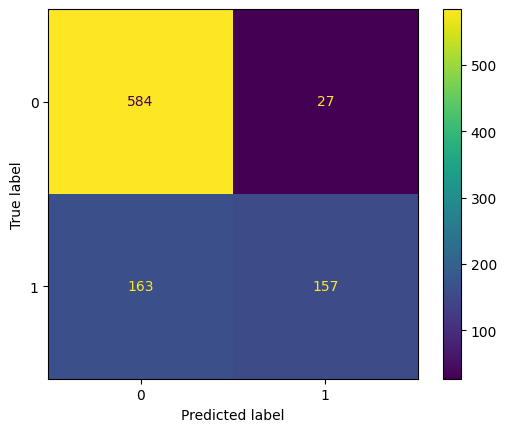

In [24]:
display_confusion_matrix(y_test, y_pred)

Обучение собственной модели с предобработкой данных и выбором лучших параметров.

In [25]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first"), cat_cols)
])

custom_improved = Pipeline([
    ("preprocess", preprocessor),
    ("select", SelectKBest(score_func=f_classif, k=10)),
    ("gb", CustomGradientBoostingClassifier(
        n_estimators=gs.best_params_["gb__n_estimators"],
        learning_rate=gs.best_params_["gb__learning_rate"],
        max_depth=gs.best_params_["gb__max_depth"]
    ))
])

custom_improved.fit(X_train, y_train)

y_pred = custom_improved.predict(X_test)
y_proba = custom_improved.predict_proba(X_test)[:, 1]

custom_improved_metrics = evaluate_classification(y_test, y_pred, y_proba)
custom_improved_metrics

{'accuracy': 0.8335123523093448,
 'precision': 0.880184331797235,
 'recall': 0.596875,
 'f1': 0.7113594040968343,
 'roc_auc': 0.8451104746317513}

Матрица ошибок

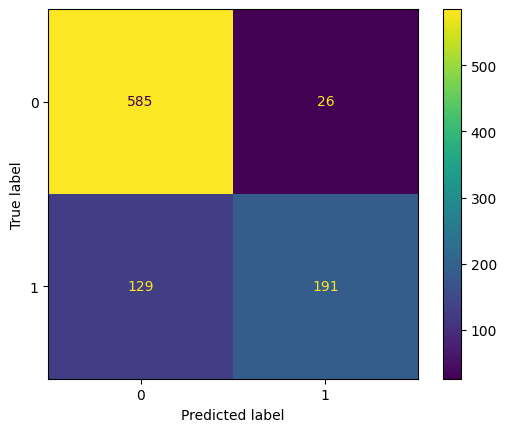

In [26]:
display_confusion_matrix(y_test, y_pred)

Итоговое сравнение всех моделей

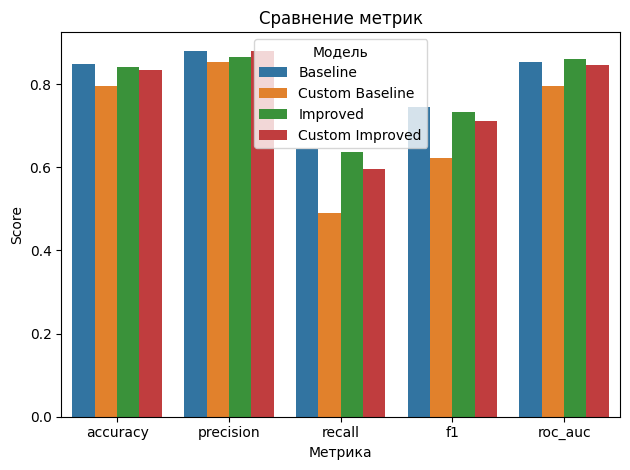

In [27]:
results = pd.DataFrame({
    "Baseline": baseline_metrics,
    "Custom Baseline": custom_base_metrics,
    "Improved": improved_metrics,
    "Custom Improved": custom_improved_metrics
})

compare_metrics(results)

Выводы: 
1. На графиках видно, что лучшие значения по метрикам демонстрируют модели с подбором оптимальных параметров, более эффективной предобработкой данных и отбором наиболее важных признаков.
2. Видно, что собственная имплементация по метрикам практически не отличается от реализации в Sklearn, значит алгоритм реализован верно. 

## Часть 2: Регрессия

Импорт библиотек для регрессии

In [28]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    root_mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error
)
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import KFold

Чтение данных для регрессии

In [29]:
df = pd.read_csv("./datasets/calories.csv")
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


Просмотр типов признаков и поиск пропущенных значений.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


Описание числовых признаков

In [31]:
df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


Разбиение выборки на тестовую и тренировочную

In [32]:
target = "Calories"

y = df[target]
X = df.drop(columns=[target])

num_cols = ["User_ID", "Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]
cat_cols = ["Gender"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

Функция вычисления метрик регрессии. 

В качестве основной метрики я использую MAPE. Эта метрика является наиболее наглядной, так как она показывает на сколько процентов модель ошибается относительно реальных значений таргета.

Дополнительно также считаются MAE, RMSE и R2

In [33]:
def evaluate_regression(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': root_mean_squared_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100
    }

### Бейзлайн

Пол кодируется с помощью OrdinalEncoder, остальные признаки остаются без изменений. После предобработки применяется GradientBoostingRegressor.

In [34]:
encoder = ColumnTransformer(
    [("cat", OrdinalEncoder(), cat_cols)],
    remainder="passthrough"
)

base = Pipeline([
    ("preprocess", encoder),
    ("gb", GradientBoostingRegressor())
])

base.fit(X_train, y_train)

y_pred = base.predict(X_test)

baseline_metrics = evaluate_regression(y_test, y_pred)
baseline_metrics

{'MAE': 2.676218674043433,
 'RMSE': 3.7583915558930037,
 'R2': 0.9964702677241403,
 'MAPE': 7.332922812328252}

### Улучшение бейзлайна

Для начала закодируем пол с помощью OrdinalEncoder, так как в этом признаке только 2 значения. И посмотрим на полученные данные.

In [35]:
encoder = ColumnTransformer([
    ("cat", OrdinalEncoder(), cat_cols),
    ("num", "passthrough", num_cols)
])

X_train_enc = encoder.fit_transform(X_train)

ohe = encoder.named_transformers_["cat"]
ohe_cols = ohe.get_feature_names_out(cat_cols)
all_cols = list(ohe_cols) + num_cols

df_plot = pd.DataFrame(X_train_enc, columns=all_cols, index=X_train.index)
df_plot[target] = y_train
df_plot.head()

,Gender,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
9996,0.0,12599049.0,54.0,178.0,71.0,9.0,88.0,40.0,41.0
3278,0.0,17298747.0,56.0,168.0,71.0,27.0,108.0,41.0,180.0
10330,0.0,15802586.0,60.0,183.0,82.0,10.0,92.0,39.2,49.0
2675,0.0,10564235.0,41.0,154.0,52.0,30.0,117.0,40.9,229.0
1442,0.0,18445846.0,32.0,173.0,68.0,10.0,87.0,39.9,41.0


Посмотрим на матрицу корреляций. По ней видно, что есть признаки, которые сильно коррелируют с таргетом.

Сильнее всего с количеством сброшенных каллорий коррелируют длительность тренировки, сердцебиение и температура тела, также есть слабая корреляция с возрастом.

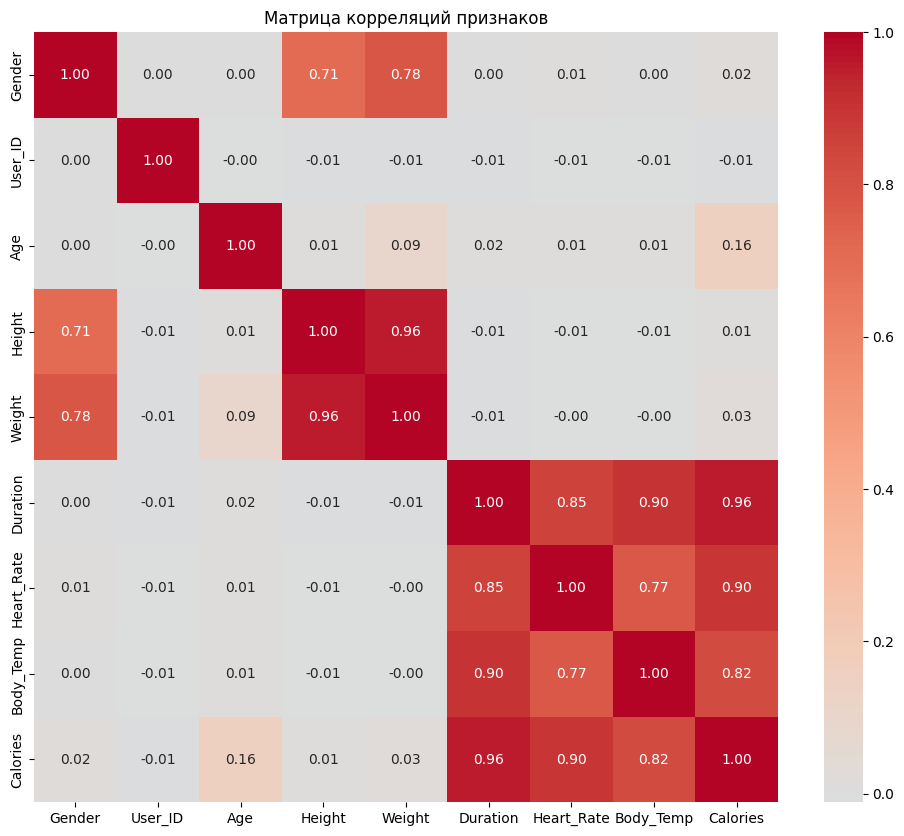

In [36]:
corr = df_plot.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Матрица корреляций признаков")
plt.show()

Посмотрим на гистограммы распределения признаков и таргета, а также на парные scatter-графики

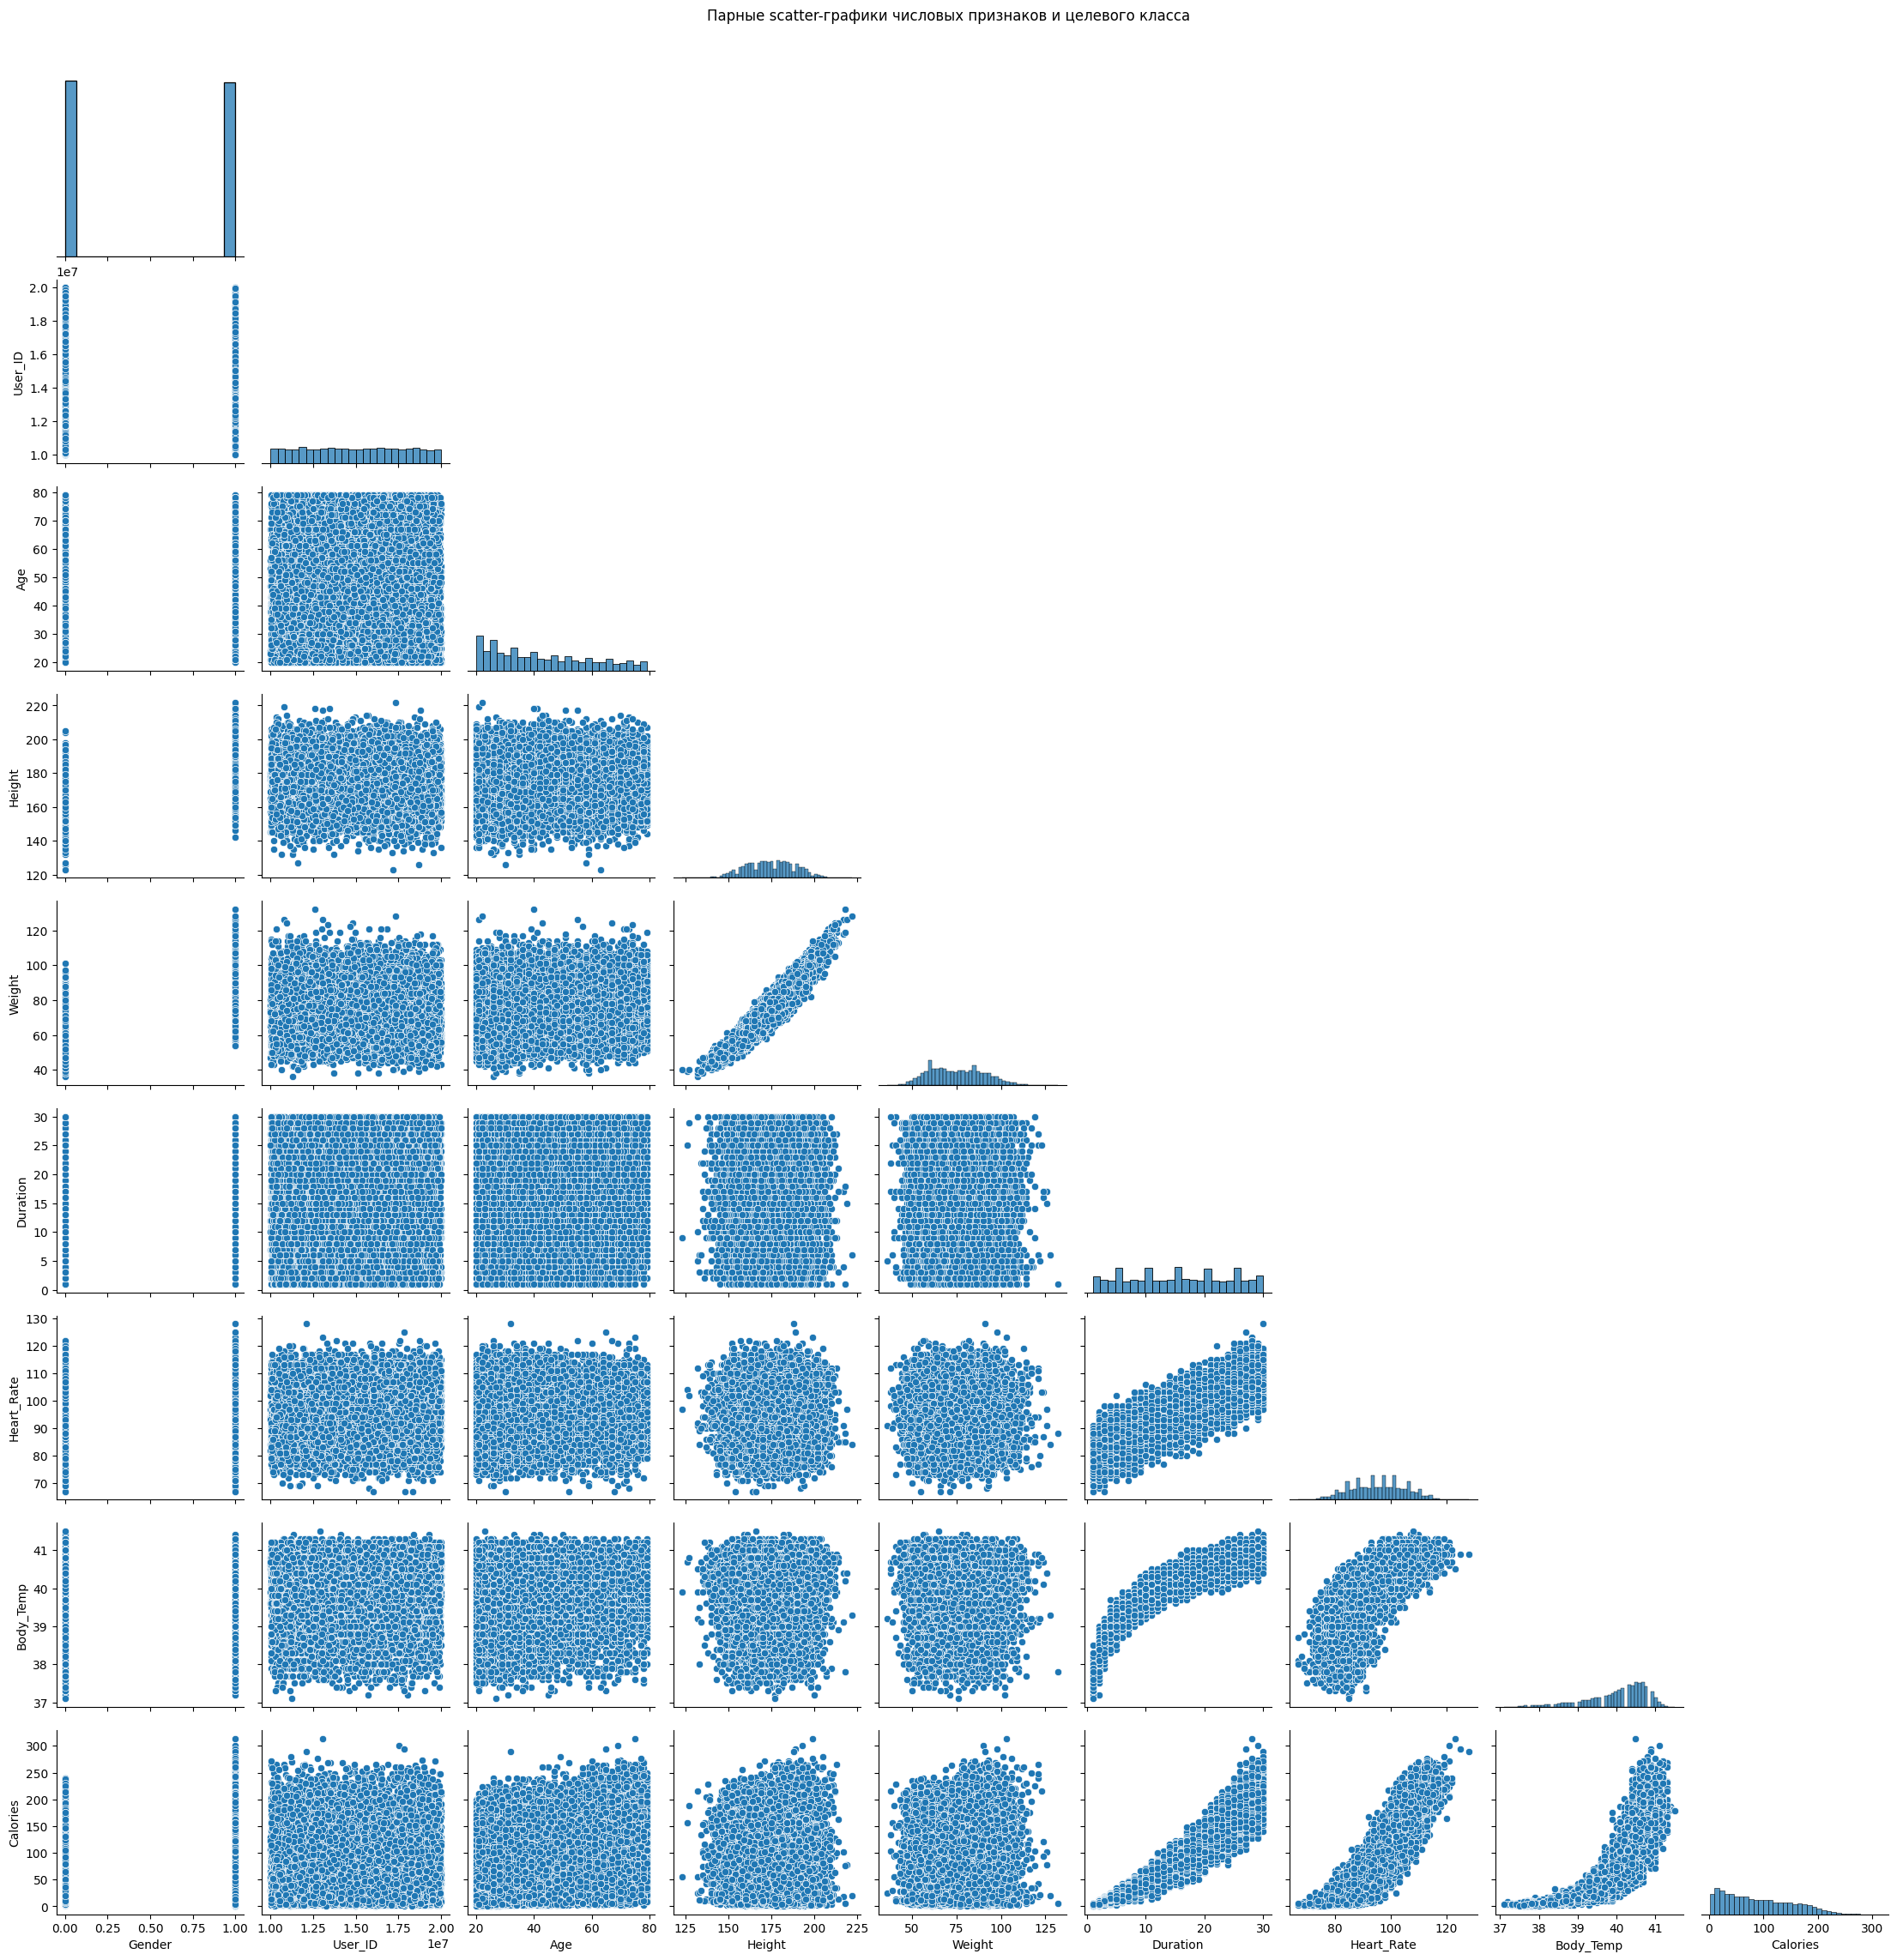

In [37]:
sns.pairplot(df_plot, corner=True)
plt.suptitle("Парные scatter-графики числовых признаков и целевого класса", y=1.02)
plt.show()


Так как все значения в признаке User_ID уникальные, этот признак можно отбросить.

In [38]:
df["User_ID"].nunique()

15000

Препроцессинг данных.

Пол кодируется с помощью OrdinalEncoder, а к числовым признакам применяется StandardScaler.

In [39]:
num_cols_drop_id = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]


encoder = ColumnTransformer([
    ("cat", OrdinalEncoder(), cat_cols),
    ("num", StandardScaler(), num_cols_drop_id)
])

improved = Pipeline([
    ("preprocess", encoder),
    ("gb", GradientBoostingRegressor())
])


Для подбора гиперпараметров используется поиск по сетке с кросс-валидацией на 5 фолдах.

In [40]:
param_grid = {
    "gb__n_estimators": [50, 100, 200],
    "gb__learning_rate": [0.01, 0.1, 0.2],
    "gb__max_depth": [3, 5, 7]
}

cv = KFold(n_splits=5, shuffle=True)

gs = GridSearchCV(
    improved, 
    param_grid,
    cv=cv,
    scoring="neg_mean_absolute_percentage_error",
    n_jobs=-1
)

gs.fit(X_train, y_train)
gs.best_params_

{'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__n_estimators': 200}

Оценка улучшенной модели

In [41]:
best_model = gs.best_estimator_

y_pred = best_model.predict(X_test)

improved_metrics = evaluate_regression(y_test, y_pred)
improved_metrics

{'MAE': 1.077951504341562,
 'RMSE': 1.7054350294875529,
 'R2': 0.9992732114495428,
 'MAPE': 1.9754688407565593}

Сравнение бейзлайна и улучшенной модели

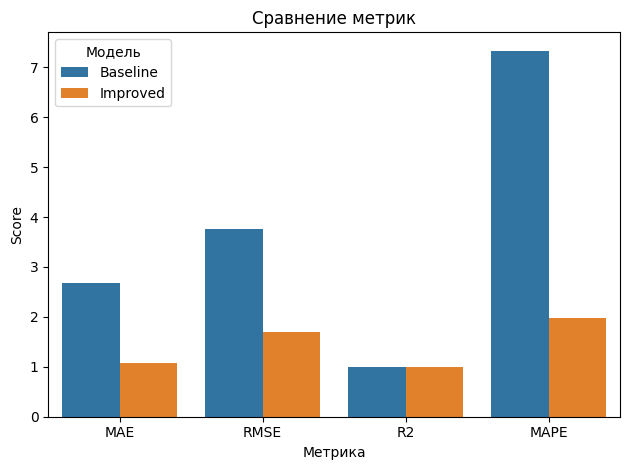

In [42]:
comparison_sklearn = pd.DataFrame({
    "Baseline": baseline_metrics,
    "Improved": improved_metrics
})
compare_metrics(comparison_sklearn)

### Имплементация решающего дерева

In [43]:
class CustomDecisionTreeRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=None,
        random_state=None,
    ):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state

    def _mse(self, y):
        return np.var(y) if len(y) > 0 else 0.0

    def _resolve_max_features(self, n_features):
        if self.max_features is None:
            return n_features
        if isinstance(self.max_features, int):
            return self.max_features
        if isinstance(self.max_features, float):
            return int(self.max_features * n_features)
        if self.max_features == "sqrt":
            return int(np.sqrt(n_features))
        if self.max_features == "log2":
            return int(np.log2(n_features))
        return n_features

    def _best_split(self, X, y):
        best_mse = np.inf
        best_feature, best_threshold = None, None

        n_features = X.shape[1]
        max_feats = self._resolve_max_features(n_features)

        feature_indices = self._rng.choice(
            n_features, max_feats, replace=False
        )

        for feature_idx in feature_indices:
            for threshold in np.unique(X[:, feature_idx]):
                left = X[:, feature_idx] <= threshold
                right = ~left

                if left.sum() < self.min_samples_leaf or right.sum() < self.min_samples_leaf:
                    continue

                mse = (
                    left.sum() * self._mse(y[left]) +
                    right.sum() * self._mse(y[right])
                ) / len(y)

                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth):
        node_value = y.mean()

        if (
            len(y) < self.min_samples_split
            or (self.max_depth is not None and depth >= self.max_depth)
        ):
            return {"value": node_value}

        feature, threshold = self._best_split(X, y)
        if feature is None:
            return {"value": node_value}

        left = X[:, feature] <= threshold
        right = ~left

        return {
            "feature": feature,
            "threshold": threshold,
            "left": self._build_tree(X[left], y[left], depth + 1),
            "right": self._build_tree(X[right], y[right], depth + 1),
        }

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y, dtype=float)

        self.n_features_in_ = X.shape[1]
        self._rng = np.random.RandomState(self.random_state)

        self.tree_ = self._build_tree(X, y, depth=0)
        return self

    def _predict_sample(self, x, node):
        if "value" in node:
            return node["value"]
        if x[node["feature"]] <= node["threshold"]:
            return self._predict_sample(x, node["left"])
        return self._predict_sample(x, node["right"])

    def predict(self, X):
        X = np.asarray(X)

        return np.array([self._predict_sample(x, self.tree_) for x in X])


Имплементация градиентного бустинга

In [44]:
class CustomGradientBoostingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1,
                 max_depth=3, min_samples_split=2, min_samples_leaf=1,
                 max_features=None, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y, dtype=float)

        self.estimators_ = []
        self._rng = np.random.RandomState(self.random_state)

        F = np.full(len(y), y.mean())
        self.init_value_ = F[0]

        for m in range(self.n_estimators):
            residual = y - F
            tree = CustomDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                random_state=self._rng.randint(0, 1_000_000)
            )
            tree.fit(X, residual)
            self.estimators_.append(tree)

            F += self.learning_rate * tree.predict(X)
            if (m + 1) % 10 == 0:
                print(f"Построено {m + 1}/{self.n_estimators} деревьев")

        return self

    def predict(self, X):
        X = np.asarray(X)
        F = np.full(X.shape[0], self.init_value_)
        for tree in self.estimators_:
            F += self.learning_rate * tree.predict(X)
        return F

Обучение собственной модели на неподготовленных данных

In [45]:
encoder = ColumnTransformer(
    [("cat", OrdinalEncoder(), cat_cols)],
    remainder="passthrough"
)

custom_base = Pipeline([
    ("preprocess", encoder),
    ("gb", CustomGradientBoostingRegressor())
])

custom_base.fit(X_train, y_train)

y_pred = custom_base.predict(X_test)

custom_base_metrics = evaluate_regression(y_test, y_pred)
custom_base_metrics

Построено 10/100 деревьев
Построено 20/100 деревьев
Построено 30/100 деревьев
Построено 40/100 деревьев
Построено 50/100 деревьев
Построено 60/100 деревьев
Построено 70/100 деревьев
Построено 80/100 деревьев
Построено 90/100 деревьев
Построено 100/100 деревьев


{'MAE': 2.676374012124548,
 'RMSE': 3.758525538912716,
 'R2': 0.9964700160565789,
 'MAPE': 7.326825258283979}

Обучение собственной модели с улучшениями

In [46]:
preprocessor = ColumnTransformer([
    ("cat", OrdinalEncoder(), cat_cols),
    ("num", StandardScaler(), num_cols_drop_id)
])

custom_improved = Pipeline([
    ("preprocess", preprocessor),
    ("gb", CustomGradientBoostingRegressor(
        n_estimators=gs.best_params_["gb__n_estimators"],
        learning_rate=gs.best_params_["gb__learning_rate"],
        max_depth=gs.best_params_["gb__max_depth"]
    ))
])

custom_improved.fit(X_train, y_train)

y_pred = custom_improved.predict(X_test)

custom_improved_metrics = evaluate_regression(y_test, y_pred)
custom_improved_metrics

Построено 10/200 деревьев
Построено 20/200 деревьев
Построено 30/200 деревьев
Построено 40/200 деревьев
Построено 50/200 деревьев
Построено 60/200 деревьев
Построено 70/200 деревьев
Построено 80/200 деревьев
Построено 90/200 деревьев
Построено 100/200 деревьев
Построено 110/200 деревьев
Построено 120/200 деревьев
Построено 130/200 деревьев
Построено 140/200 деревьев
Построено 150/200 деревьев
Построено 160/200 деревьев
Построено 170/200 деревьев
Построено 180/200 деревьев
Построено 190/200 деревьев
Построено 200/200 деревьев


{'MAE': 1.069494934735474,
 'RMSE': 1.6586140108516572,
 'R2': 0.9993125701630906,
 'MAPE': 1.9759170907371781}

Итоговое сравнение всех моделей

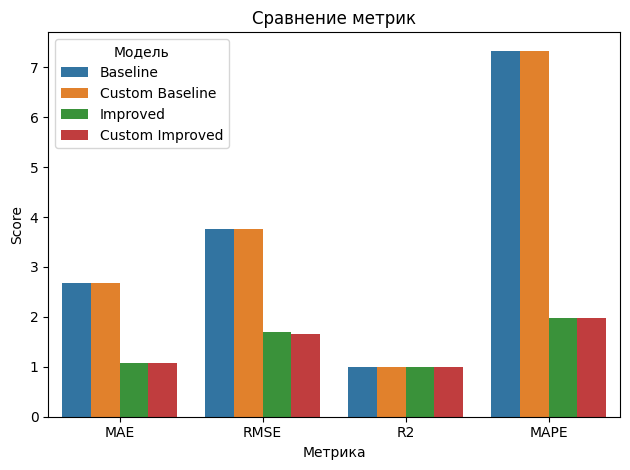

In [47]:
results = pd.DataFrame({
    "Baseline": baseline_metrics,
    "Custom Baseline": custom_base_metrics,
    "Improved": improved_metrics,
    "Custom Improved": custom_improved_metrics
})

compare_metrics(results)

Выводы: 
1. Лучшие результаты продемонстрировали модели, которые использовали оптимальные гиперпараметры и применялись после масштабирования признаков.
2. Собственная реализация бустинга показала результаты, близкие к реализации из sklearn, что подтверждает корректность реализации.